<a href="https://colab.research.google.com/github/jocelynbaduria/Assignment-6_part_abcde/blob/main/Jocelyn_Baduria_cmpe258_Assignment6_b_keras_foodimages.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

B. CNN based image classifier using Keras (food images)

---



Download Images


In [30]:
import zipfile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [31]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

--2021-05-01 02:08:09--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.125.128, 74.125.23.128, 74.125.203.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.125.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip.3’

10_food_classes_all 100%[===================>] 495.13M   147MB/s    in 3.4s    

2021-05-01 02:08:12 (147 MB/s) - ‘10_food_classes_all_data.zip.3’ saved [519183241/519183241]



In [32]:
# Unzip the downloaded file
def unzip_data(filename):
  """
  Utility function to unzip a zipped file.
  """
  zip_ref = zipfile.ZipFile(filename, "r")
  zip_ref.extractall()
  zip_ref.close()

In [33]:
unzip_data("10_food_classes_all_data.zip")

In [34]:
!ls 10_food_classes_all_data

test  train


In [35]:
# Setup data inputs
IMG_SIZE = (224, 224)

def create_data_loaders(train_dir, test_dir, image_size=IMG_SIZE):
  """
  Creates a training and test image BatchDataset from train_dir and test_dir.
  """
  train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                  label_mode="categorical",
                                                                  image_size=image_size)
  # Note: the test data is the same as the previous experiment, we could
  # skip creating this, but we'll leave this here to practice.
  test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                  label_mode="categorical",
                                                                  image_size=image_size)
  
  return train_data, test_data

In [36]:
# Create a data augmentation stage with horizontal flipping, rotations, zooms
data_augmentation = keras.Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetB0
], name ="data_augmentation")

In [37]:
# Setup input shape and base model, freezing the base model layers
INPUT_SHAPE = (224, 224, 3)
BASE_MODEL = tf.keras.applications.EfficientNetB0(include_top=False)

def create_model(input_shape=INPUT_SHAPE, base_model=BASE_MODEL, num_classes=10):
  # Fine-tune?
  base_model.trainable = False

  # Create input layer
  inputs = layers.Input(shape=input_shape, name="input_layer")

  # Add in data augmentation Sequential model as a layer
  x = data_augmentation(inputs)

  # Give base_model inputs (after augmentation) and don't train it
  x = base_model(x, training=False)

  # Pool output features of base model
  x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

  # Put a dense layer on as the output
  outputs = layers.Dense(num_classes, activation="softmax", name="output_layer")(x)

  # Make a model with inputs and outputs
  model = keras.Model(inputs, outputs)

  # Compile the model
  model.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
  
  return model

In [38]:
# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224, scale=False):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.image.decode_jpeg(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  # Rescale the image (get all values between 0 and 1)
  if scale:
    return img/255.
  else:
    return img

In [39]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_all_data"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/test'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/steak'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_curry'.
There are 

In [40]:
# Check the file in 10_food_classes_10_percent
!ls -la 10_food_classes_all_data

total 16
drwxr-xr-x  4 root root 4096 May  1 01:47 .
drwxr-xr-x  1 root root 4096 May  1 02:08 ..
drwxr-xr-x 12 root root 4096 May  1 01:47 test
drwxr-xr-x 12 root root 4096 May  1 01:47 train


In [41]:
# Create tensorboard callback (functionized because need to create a new one for each model)
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

Create a Model Training

In [42]:
# Create BatchDataset
train_data, test_data = create_data_loaders(train_dir="10_food_classes_all_data/train/",
                                            test_dir="10_food_classes_all_data/test/")

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [43]:
# Create model
model_1 = create_model(num_classes=len(train_data.class_names))

# Fit the model
history_1_percent = model_1.fit(train_data,
                    epochs=5,
                    steps_per_epoch=len(train_data),
                    validation_data=test_data,
                    validation_steps=int(0.25 * len(test_data)), # validate for less steps
                    # Track model training logs
                    callbacks=[create_tensorboard_callback("transfer_learning", "all_data_aug")])

Saving TensorBoard log files to: transfer_learning/all_data_aug/20210501-020826
Epoch 1/5
235/235 [==============================] - 596s 2s/step - loss: 1.4444 - accuracy: 0.5564 - val_loss: 0.5575 - val_accuracy: 0.8240
Epoch 2/5
235/235 [==============================] - 578s 2s/step - loss: 0.7157 - accuracy: 0.7773 - val_loss: 0.4625 - val_accuracy: 0.8487
Epoch 3/5
235/235 [==============================] - 579s 2s/step - loss: 0.6268 - accuracy: 0.8072 - val_loss: 0.4004 - val_accuracy: 0.8701
Epoch 4/5
235/235 [==============================] - 572s 2s/step - loss: 0.5774 - accuracy: 0.8202 - val_loss: 0.3892 - val_accuracy: 0.8750
Epoch 5/5
235/235 [==============================] - 585s 2s/step - loss: 0.5511 - accuracy: 0.8242 - val_loss: 0.3905 - val_accuracy: 0.8701


In [47]:
# Get an image Tensor
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-pizza-dad.jpeg

--2021-05-01 03:08:36--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-pizza-dad.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2874848 (2.7M) [image/jpeg]
Saving to: ‘03-pizza-dad.jpeg’

03-pizza-dad.jpeg   100%[===================>]   2.74M  --.-KB/s    in 0.1s    

2021-05-01 03:08:37 (19.8 MB/s) - ‘03-pizza-dad.jpeg’ saved [2874848/2874848]



In [48]:
# Classes our model is trained on
class_names = train_data.class_names
class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [52]:
# Preprocess image
pizza_img = load_and_prep_image("03-pizza-dad.jpeg")

In [53]:
print(pizza_img)

tf.Tensor(
[[[ 73.625  76.75   67.125]
  [114.    122.    101.   ]
  [146.875 151.875 129.875]
  ...
  [ 14.5    17.5    10.5  ]
  [ 14.25   19.25   12.25 ]
  [ 19.75   22.75   15.75 ]]

 [[239.125 243.625 246.125]
  [225.375 232.125 234.875]
  [240.    245.    244.5  ]
  ...
  [ 11.     14.      7.   ]
  [ 20.     23.     16.   ]
  [ 20.875  25.875  18.875]]

 [[ 32.5    34.5    31.5  ]
  [ 44.625  44.5    42.375]
  [ 33.     38.     34.   ]
  ...
  [  8.75   13.25    6.25 ]
  [ 14.875  17.875  10.875]
  [ 13.625  20.625  12.625]]

 ...

 [[ 61.875  40.875  19.875]
  [ 60.     42.     22.   ]
  [ 61.     43.     21.   ]
  ...
  [134.5    96.125  60.75 ]
  [104.875  69.375  43.125]
  [106.25   75.25   46.25 ]]

 [[ 62.75   44.75   24.75 ]
  [ 61.125  43.125  23.125]
  [ 58.125  40.125  20.125]
  ...
  [159.125 111.125  64.625]
  [160.375 112.375  66.375]
  [134.     94.125  56.75 ]]

 [[ 59.625  42.625  22.625]
  [ 61.75   43.75   22.5  ]
  [ 59.25   41.25   21.25 ]
  ...
  [161.5   11

In [75]:
# Make predictions
pizza_expanded = tf.expand_dims(pizza_img, axis=0) # expand image dimensions (224, 224, 3) -> (1, 224, 224, 3)
pred = model_1.predict(pizza_expanded)
pred

array([[5.8958344e-03, 2.6990494e-05, 3.3113139e-04, 1.3801754e-04,
        2.5877202e-06, 1.1752647e-06, 9.9270952e-01, 2.2431467e-04,
        7.7706420e-05, 5.9265993e-04]], dtype=float32)

In [76]:
# Check the predicted class
class_names[tf.argmax(pred[0])]

'pizza'

In [106]:
import matplotlib.pyplot as plt

def pred_and_plot(model, image, class_names):
  pred_probs = model.predict(tf.expand_dims(image, axis=0))
  pred_class = class_names[tf.argmax(pred_probs[0])]
  
  plt.figure()
  plt.imshow(image)
  # plt.imshow(tf.argmax(pred[0]).astype("uint8"))
  plt.title(f"{pred_class}, prob: {tf.reduce_max(pred_probs):.2f}")
  plt.axis(False);

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


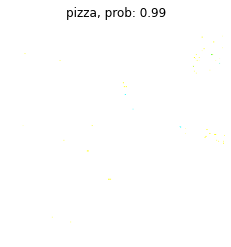

In [107]:
pred_and_plot(model=model_1,
              image=pizza_img,
              class_names=train_data.class_names)